In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import librosa
import torch
import torchaudio.functional as F
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio, display

import augmentations.augmentations.misc as misc

from data.data_generator import (
    AudioSetDataset,
    BalancedTrainSampler,
    EvaluateSampler,
    collate_fn,
)

In [2]:
def audio_to_melspectrogram(audio, sampling_rate, hop_length=256, n_fft=2048):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, sr=sampling_rate, hop_length=hop_length, n_fft=n_fft
    )
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(
    spectrogram, sampling_rate, title="log-frequency power spectrogram"
):
    librosa.display.specshow(spectrogram, x_axis="time", y_axis="mel", sr=sampling_rate)
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.show()


def show_signal(audio):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()


def show_and_play_signal(audio, sample_rate):
    plt.plot(audio)
    plt.title("Signal")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()
    display(Audio(audio, rate=sample_rate))


def read_as_melspectrogram(file_path):
    audio, sampling_rate = misc.load_audio(file_path)
    spectrogram = audio_to_melspectrogram(audio, sampling_rate)
    return spectrogram

In [3]:
data_root = "/home/klig/datasets/audioset/"
data_type = "balanced_train"  # "full_train"

train_indexes_hdf5_path = os.path.join(
    data_root, "hdf5s", "indexes", "{}.h5".format(data_type)
)

eval_bal_indexes_hdf5_path = os.path.join(
    data_root, "hdf5s", "indexes", "balanced_train.h5"
)

eval_test_indexes_hdf5_path = os.path.join(data_root, "hdf5s", "indexes", "eval.h5")

In [4]:
batch_size = 32
sample_rate = 8000
augmentation = "mixup"
black_list_csv = "metadata/dcase2017task4.csv"
num_workers = 4

dataset = AudioSetDataset()

sampler = EvaluateSampler(
    indexes_hdf5_path=eval_bal_indexes_hdf5_path, batch_size=batch_size
)

loader = torch.utils.data.DataLoader(
    dataset=dataset,
    batch_sampler=sampler,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=True,
)

In [5]:
batch = next(iter(loader))

In [18]:
from augmentations.augmentations import (
    Compose,
    RandomRIR,
    RandomBackgroundNoise,
    RandomEncoder,
    RandomApply,
)

sample_rate = 8000
transforms = Compose(
    [
        RandomApply(
            RandomBackgroundNoise(
                noise_root="/media/klig/disk/datasets/arabic-natural-audio",
                sample_rate=sample_rate,
                segment_size=sample_rate * 10,
                bank_size=128,
                snr_dbs_range=[20, 30],
            ),
            0.25,
        ),
        RandomApply(RandomRIR(), 0.3),
        RandomEncoder(sample_rate=sample_rate),
    ]
)

dataset_trans = AudioSetDataset(transforms=transforms)
loader_trans = torch.utils.data.DataLoader(
    dataset=dataset_trans,
    batch_sampler=sampler,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=True,
)

In [19]:
batch_trans = next(iter(loader_trans))

[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())
[W encode_process.cpp:170] Warning: "vorbis" encoder is selected. Enabling '-strict experimental'. If this is not desired, please provide "strict" encoder option with desired value. (function operator())


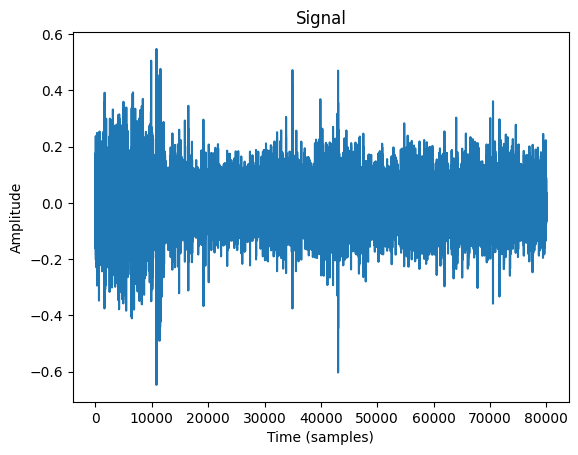

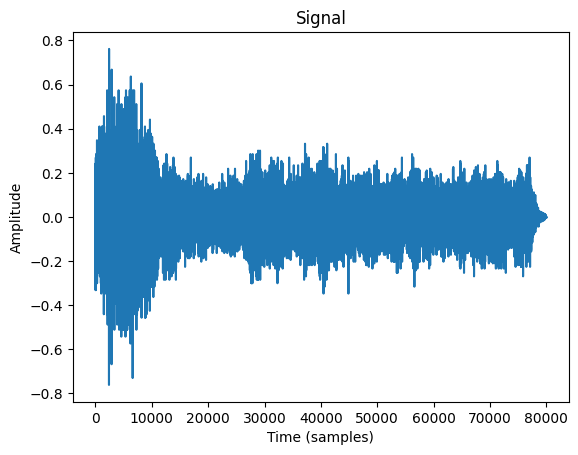

In [20]:
index = 8
audio = batch["waveform"][index]
show_and_play_signal(audio, sample_rate)
audio = batch_trans["waveform"][index]
show_and_play_signal(audio, sample_rate)